# **Sales Price Prediction**

## Objectives

* Fit and evaluate a classification model to predic house sales price.

## Inputs

outputs/datasets/cleaned/clean_house_price_records.csv

## Outputs

* Train set 
* Test set
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot

## Additional Comments

* This file and its contents were inspired by and adapted from the Churnometer Walkthrough Project 2.  

---

### Change working directory

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/housing-prices/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/housing-prices'

### Load Data

Load dataset:

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/clean_house_price_records.csv"))
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854,3,No,706,GLQ,150,548,RFn,2003,...,8450,65,196,61,5,7,856,2003,2003,208500
1,1262,0,3,Gd,978,ALQ,284,460,RFn,1976,...,9600,80,0,0,8,6,1262,1976,1976,181500
2,920,866,3,Mn,486,GLQ,434,608,RFn,2001,...,11250,68,162,42,5,7,920,2001,2002,223500
3,961,0,0,No,216,ALQ,540,642,Unf,1998,...,9550,60,0,35,5,7,756,1915,1970,140000
4,1145,0,4,Av,655,GLQ,490,836,RFn,2000,...,14260,84,350,84,5,8,1145,2000,2000,250000


### ML Pipeline with all data

- ML pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine import transformation as vt
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.impute import SimpleImputer
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer 
import pandas as pd

selection_method = "cardinality"
corr_method = "spearman"

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("NumericMissingValueImputer", MeanMedianImputer(imputation_method='median',
                                                         variables=['1stFlrSF', 'LotArea', 'GrLivArea', 
                                                                    'MasVnrArea', 'OpenPorchSF'])),
        
        ("CategoricalMissingValueImputer", CategoricalImputer(imputation_method='frequent',
                                                              variables=['BsmtExposure', 'BsmtFinType1', 
                                                                         'GarageFinish', 'KitchenQual'])),
        
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 
                                                                'GarageFinish', 'KitchenQual'])),
        
        ("NumericLogTransform", vt.LogTransformer(variables=['1stFlrSF', 'LotArea', 'GrLivArea'])),
        
        ("NumericPowerTransform", vt.PowerTransformer(variables=['MasVnrArea'])),
        
        ("NumericYeoJohnsonTransform", vt.YeoJohnsonTransformer(variables=['OpenPorchSF'])),
        
        ("feat_scaling", StandardScaler()),

        ("FinalImputer", SimpleImputer(strategy="mean")),

        ("feat_selection", SelectFromModel(model)),
        
        ("model", model),
        
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation

In [6]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Split Train and Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)


print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Grid Search CV - Sklearn

#### Use standard hyperparameters to find most suitable algorithm

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Quick GridSearch CV - Binary Classifier

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.700011,0.820106,0.875153,0.062233
0,LinearRegression,0.735068,0.803819,0.846027,0.03773
5,GradientBoostingRegressor,0.61232,0.764237,0.831469,0.079255
4,AdaBoostRegressor,0.670095,0.757476,0.785685,0.044446
2,RandomForestRegressor,0.630557,0.715722,0.817748,0.071603
6,XGBRegressor,0.516448,0.650623,0.751455,0.087641
1,DecisionTreeRegressor,0.488006,0.575755,0.667303,0.067595


- Top Model Performance: ExtraTreesRegressor achieved the highest average R2 score at 0.82, surpassing the client’s requirement of at least 0.75 for model selection.

- Variability Across Models: While ExtraTreesRegressor and LinearRegression performed well with mean scores above 0.80, other models like RandomForestRegressor and XGBRegressor showed lower average R2 scores, particularly XGBRegressor, with an average score of 0.65.

- Standard Deviation Insights: The lower standard deviation in models like LinearRegression suggests consistent performance, while models such as GradientBoostingRegressor showed greater variability, indicating more fluctuation in R2 scores across different test sets.

#### Extensive search to the most suitable model

In this code, we define a model search for optimizing hyperparameters specifically for the `ExtraTreesRegressor` model. We set up a range of values for each key hyperparameter:

- `n_estimators`: Number of trees in the forest.
- `max_depth`: Maximum depth of each tree.
- `min_samples_split`: Minimum number of samples required to split an internal node.
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node.

In [11]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300, 500],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    }
}

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 81 candidates, totalling 405 fits


,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
43,ExtraTreesRegressor,0.762708,0.838347,0.877812,0.043091,20,2,10,300
70,ExtraTreesRegressor,0.763084,0.838289,0.877655,0.042896,None,2,10,300
69,ExtraTreesRegressor,0.761929,0.838163,0.87839,0.042981,None,2,10,100
42,ExtraTreesRegressor,0.761524,0.838031,0.878519,0.043101,20,2,10,100
44,ExtraTreesRegressor,0.764677,0.837931,0.877652,0.042333,20,2,10,500
...,...,...,...,...,...,...,...,...,...
30,ExtraTreesRegressor,0.701235,0.821148,0.876126,0.062437,20,1,5,100
28,ExtraTreesRegressor,0.691711,0.820521,0.875276,0.066054,20,1,2,300
55,ExtraTreesRegressor,0.693244,0.820305,0.87753,0.065543,None,1,2,300
54,ExtraTreesRegressor,0.700011,0.820106,0.875153,0.062233,None,1,2,100


Defining the best model:

In [12]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

In [13]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 20,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 10,
 'model__n_estimators': 300}

Defining the best regressor:

In [14]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('NumericMissingValueImputer',
                 MeanMedianImputer(variables=['1stFlrSF', 'LotArea',
                                              'GrLivArea', 'MasVnrArea',
                                              'OpenPorchSF'])),
                ('CategoricalMissingValueImputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtExposure', 'BsmtFinType1',
                                               'GarageFinish',
                                               'KitchenQual'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_meth...
                 PowerTransformer(variables=['MasVnrArea'])),
                ('NumericYeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['OpenPorchSF'])),
                ('feat_scaling', StandardScaler()),
                ('FinalImputer', SimpleImputer()),
                ('feat_selection',
             

### Assess feature importance

* These are the 6 most important features in descending order. The model was trained on: 
['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']


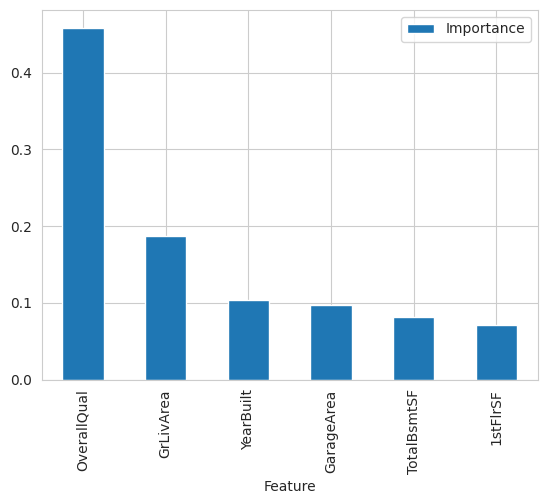

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 6 
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate on Train and Test Sets

In [16]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.925
Mean Absolute Error: 13475.052
Mean Squared Error: 460627725.683
Root Mean Squared Error: 21462.24


* Test Set
R2 Score: 0.816
Mean Absolute Error: 20103.7
Mean Squared Error: 1268866285.037
Root Mean Squared Error: 35621.149




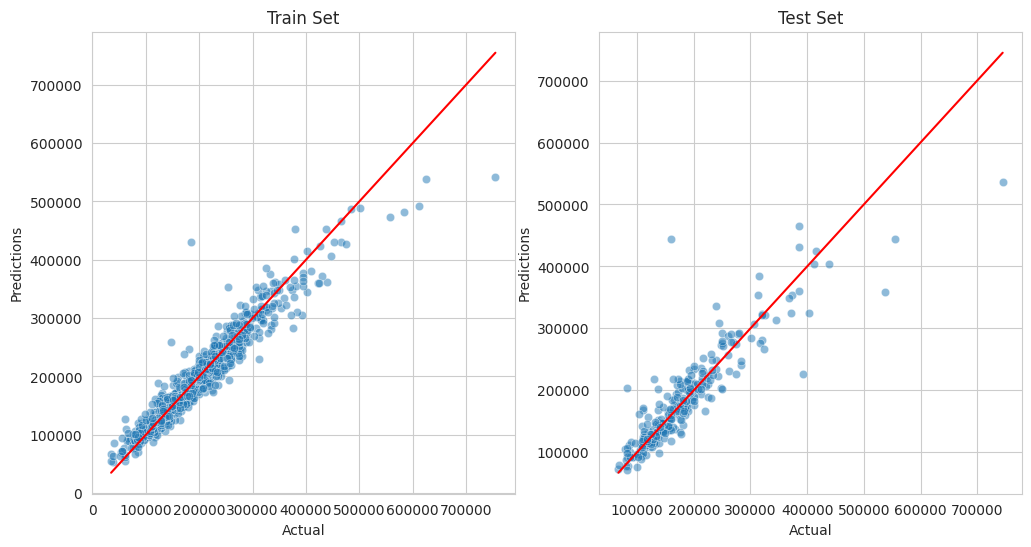

In [17]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### Regressor with Principal Component Analysis

potential values for Principal Component n_components.

In [18]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:8])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 21) 
 <class 'numpy.ndarray'>


Apply PCA separately to the scaled data

* The 21 components explain 100.0% of the data 



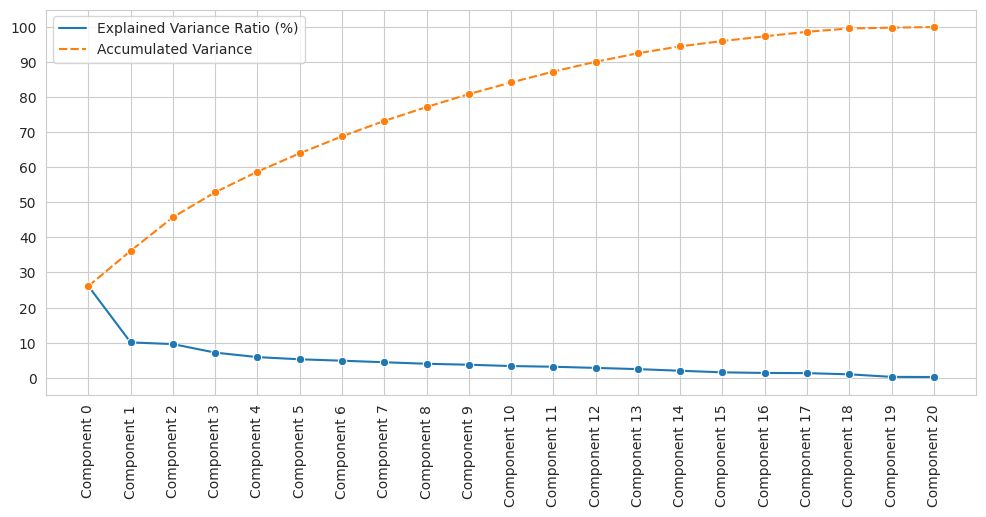

In [19]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 21


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 7 components explain 68.82% of the data 



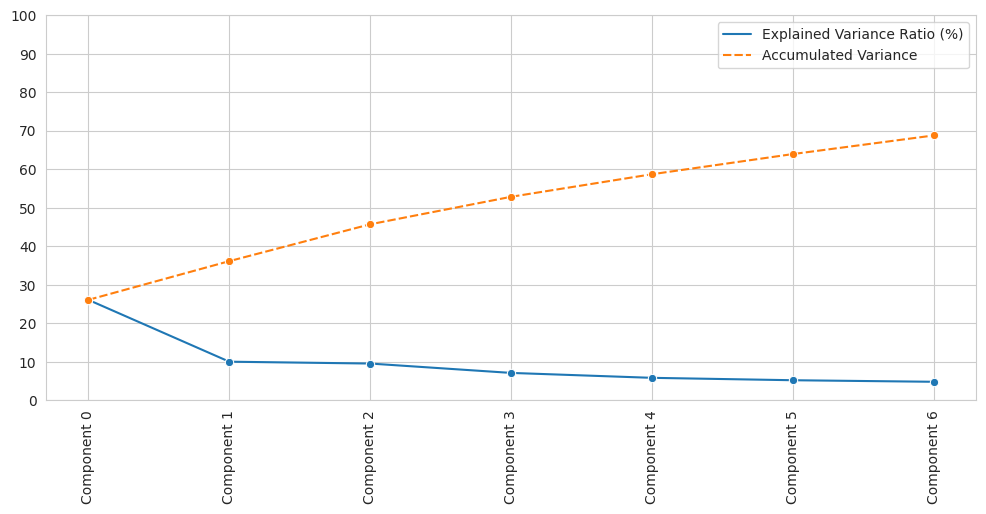

In [50]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

### Rewrite ML Pipeline for Modelling

Analysis of Numerical Variables: Skewness and Correlation

1stFlrSF: Skewness = 1.38


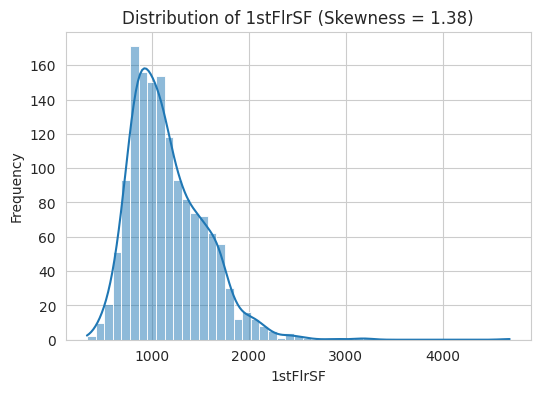

LotArea: Skewness = 12.20


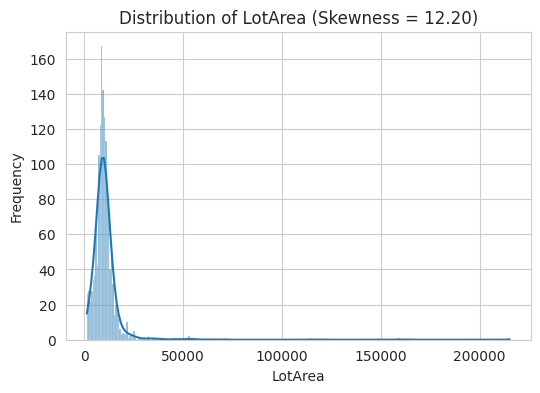

GrLivArea: Skewness = 1.37


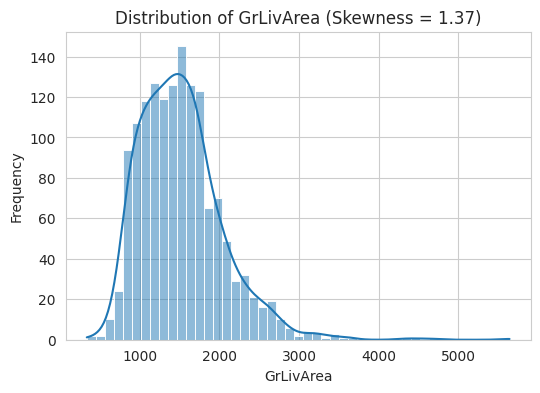

GarageArea: Skewness = 0.18


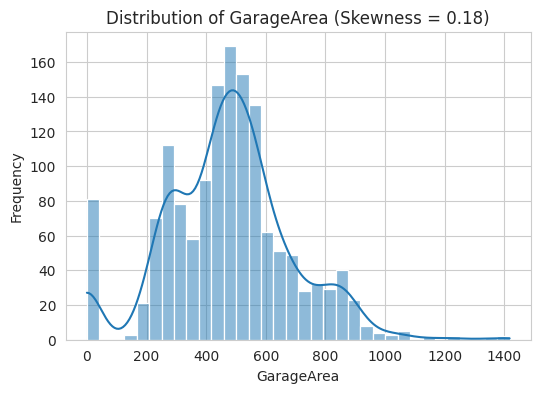

MasVnrArea: Skewness = 2.67


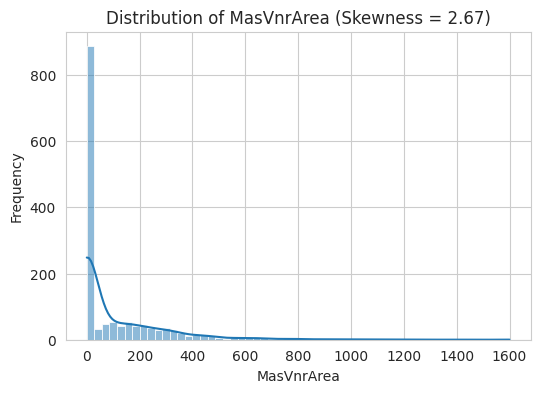

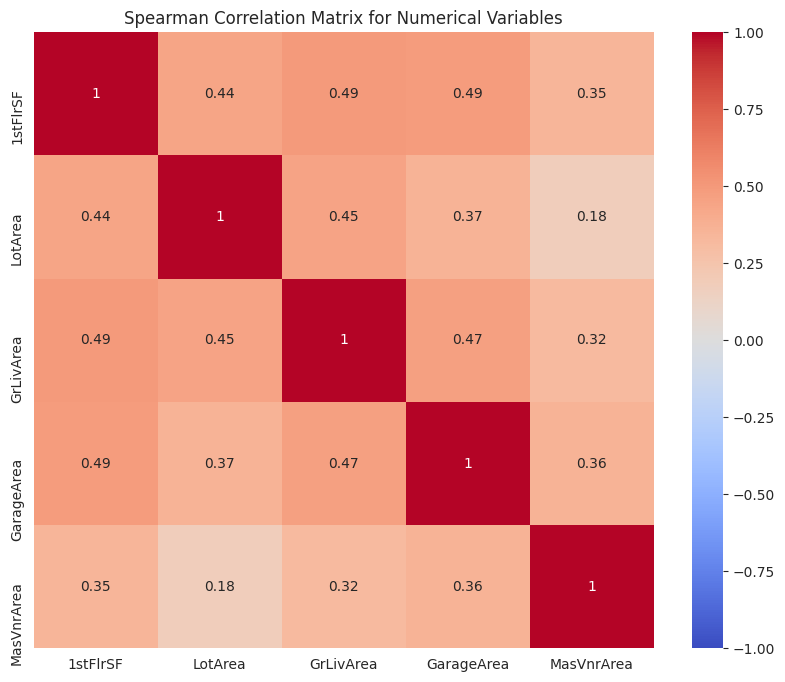

            1stFlrSF   LotArea  GrLivArea  GarageArea  MasVnrArea
1stFlrSF    1.000000  0.443858   0.494421    0.489797    0.348863
LotArea     0.443858  1.000000   0.449040    0.367153    0.175909
GrLivArea   0.494421  0.449040   1.000000    0.468211    0.318580
GarageArea  0.489797  0.367153   0.468211    1.000000    0.360858
MasVnrArea  0.348863  0.175909   0.318580    0.360858    1.000000


In [51]:
from scipy.stats import skew
data_path = "outputs/datasets/cleaned/clean_house_price_records.csv"
df = pd.read_csv(data_path)

numerical_columns = ['1stFlrSF', 'LotArea', 'GrLivArea', 'GarageArea', 'MasVnrArea']

df = df[[col for col in numerical_columns if col in df.columns]]

for col in df.columns:
    col_skew = skew(df[col].dropna())
    print(f"{col}: Skewness = {col_skew:.2f}")
    
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col} (Skewness = {col_skew:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

correlation_matrix = df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Spearman Correlation Matrix for Numerical Variables")
plt.show()

print(correlation_matrix)

Pipeline(steps=[('NumericMissingValueImputer',
                 MeanMedianImputer(variables=['1stFlrSF', 'LotArea',
                                              'GrLivArea', 'MasVnrArea',
                                              'OpenPorchSF'])),
                ('CategoricalMissingValueImputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtExposure', 'BsmtFinType1',
                                               'GarageFinish',
                                               'KitchenQual'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_meth...
                 PowerTransformer(variables=['MasVnrArea'])),
                ('NumericYeoJohnsonTransform',
                 YeoJohnsonTransformer(variables=['OpenPorchSF'])),
                ('feat_scaling', StandardScaler()),
                ('FinalImputer', SimpleImputer()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=20, min_samples_leaf=2,
                                     min_samples_split=10, n_estimators=300,
                                     random_state=0))])

In [ ]:
def PipelineOptimization(model, n_components=7):
    pipeline_base = Pipeline([
        ("NumericMissingValueImputer", MeanMedianImputer(variables=['1stFlrSF', 'LotArea', 'GrLivArea', 'MasVnrArea', 'OpenPorchSF'])),
        
        ("CategoricalMissingValueImputer", CategoricalImputer(imputation_method='frequent', 
                                                              variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        
        ("NumericLogTransform", LogTransformer(variables=['1stFlrSF', 'LotArea', 'GrLivArea'])),
        
        ("NumericPowerTransform", PowerTransformer(variables=['GarageArea', 'MasVnrArea'])),
        
        ("NumericYeoJohnsonTransform", YeoJohnsonTransformer(variables=['OpenPorchSF'])),
        
        ("feat_scaling", StandardScaler()),
        
        ("PCA", PCA(n_components=n_components, random_state=0)),
        
        ("FinalImputer", SimpleImputer()),
        
        ("feat_selection", SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
        
        ("model", model),
    ])
    
    return pipeline_base

### Grid Search CV – Sklearn

In [67]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


In [68]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Quick optimisation search

In [69]:
from feature_engine.transformation import LogTransformer, PowerTransformer, YeoJohnsonTransformer

quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results:

In [70]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.591721,0.760374,0.809751,0.084601
4,AdaBoostRegressor,0.587571,0.740283,0.806546,0.078968
0,LinearRegression,0.673801,0.72918,0.773039,0.041361
2,RandomForestRegressor,0.627483,0.722699,0.77073,0.050722
6,XGBRegressor,0.541187,0.705624,0.77726,0.083992
3,ExtraTreesRegressor,0.50151,0.664695,0.736653,0.08851
1,DecisionTreeRegressor,0.455818,0.63027,0.725835,0.095531


#### Extensive search on the most suitable model to find the best hyperparameter configuration

Define model and parameters for extensive search